## Analyze Diminishing Response Acccuracy

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(os.path.join('..', 'data', f'robyn_toy_data_2paidvar_bal_eff2ratio_dimret_600000err.csv'))
print(df.head(2))
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
df.info()

         date    tv    fb  context_0_center  context_100_center  \
0  2015-01-01  3392  4783         -1.012228           98.987772   
1  2015-01-02  2303  4496          1.927733          101.927733   

   fb_contribution  tv_contribution  bookings_noiseless  bookings_noisy  \
0           994832           678400            11673232    1.134510e+07   
1           974975           460600            11435575    9.941349e+06   

   bookings_noisy_context  
0            1.053531e+07  
1            1.148354e+07  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    2557 non-null   datetime64[ns]
 1   tv                      2557 non-null   int64         
 2   fb                      2557 non-null   int64         
 3   context_0_center        2557 non-null   float64       
 4   context_100_cent

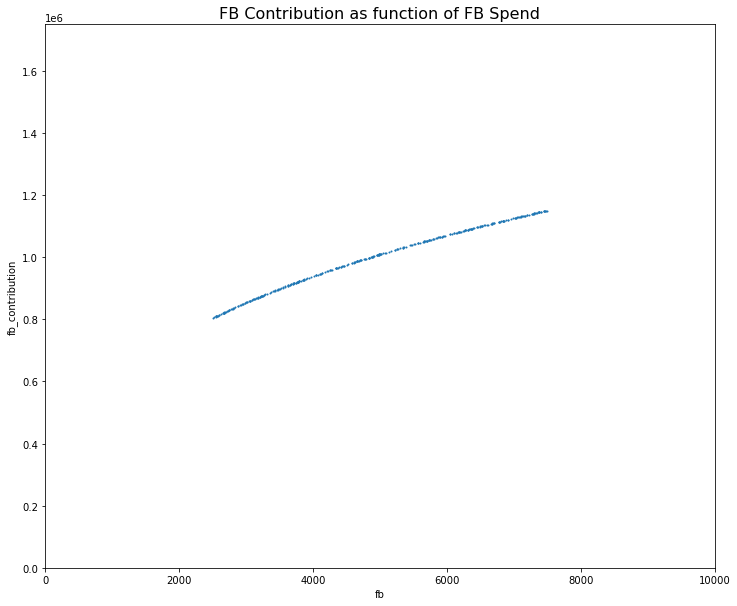

In [3]:
df2021 = df[df['date'] >= pd.to_datetime('2021/01/01', format='%Y/%m/%d')]
ax=df2021.plot.scatter(y='fb_contribution', x='fb', s=1, figsize=(12, 10))
_=ax.set_title('FB Contribution as function of FB Spend', fontsize=16)
_=ax.set_ylim(0, 1750000)
_=ax.set_xlim(0, 10000)

In [4]:
resdf = pd.read_csv(os.path.join('..', 'robyn_output', '2022-02-01_18.45_init', 'pareto_media_transform_matrix.csv'))
resdf['date'] = pd.to_datetime(resdf.ds, format='%Y-%m-%d')
resdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703087 entries, 0 to 703086
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      703087 non-null  object        
 1   tv      703087 non-null  float64       
 2   fb      703087 non-null  float64       
 3   type    703087 non-null  object        
 4   solID   703087 non-null  object        
 5   date    703087 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 32.2+ MB


In [5]:
resdf2021 = resdf[resdf['date'] >= pd.to_datetime('2021/01/01', format='%Y/%m/%d')]
resdf2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196735 entries, 2192 to 703086
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ds      196735 non-null  object        
 1   tv      196735 non-null  float64       
 2   fb      196735 non-null  float64       
 3   type    196735 non-null  object        
 4   solID   196735 non-null  object        
 5   date    196735 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 10.5+ MB


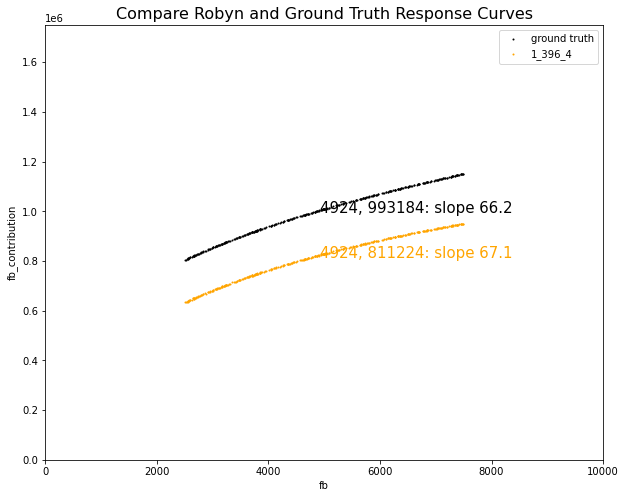

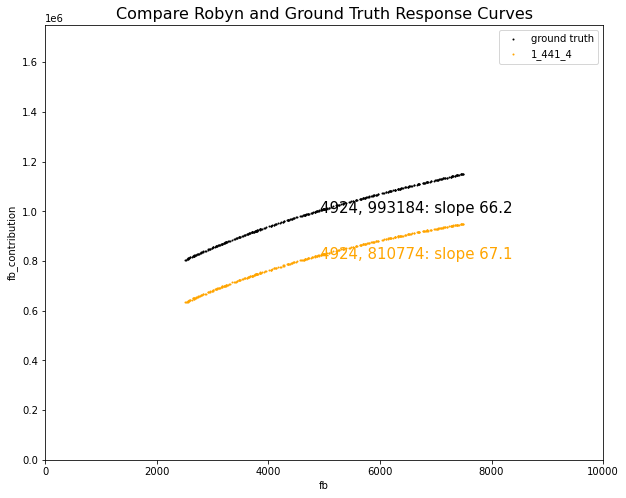

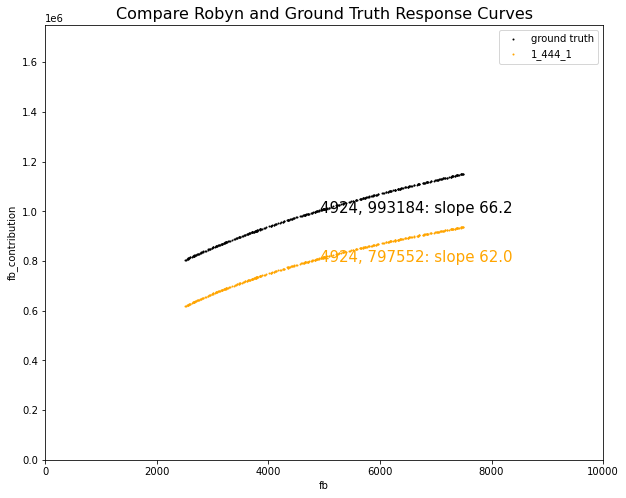

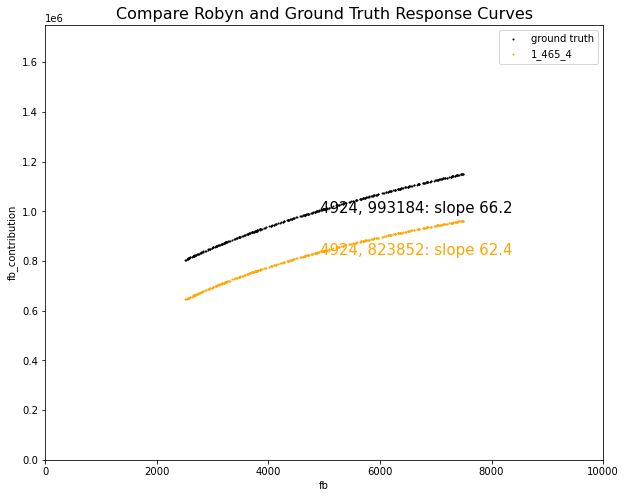

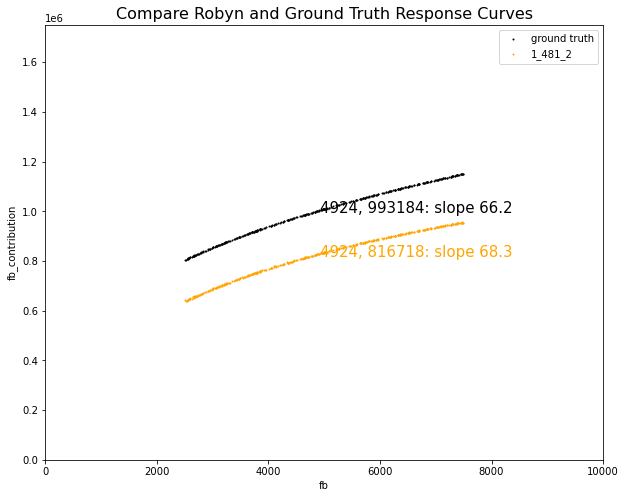

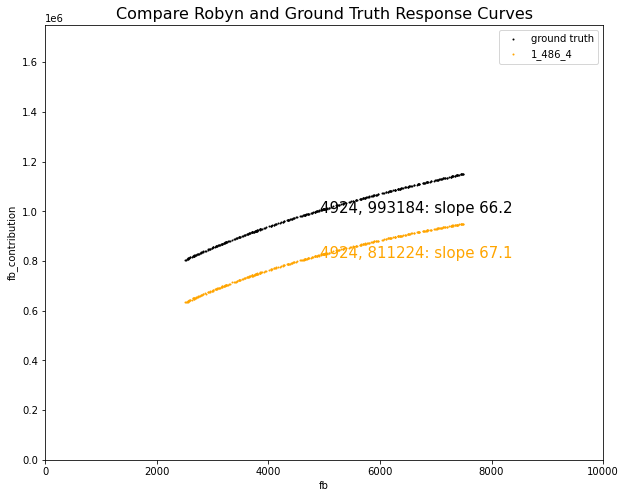

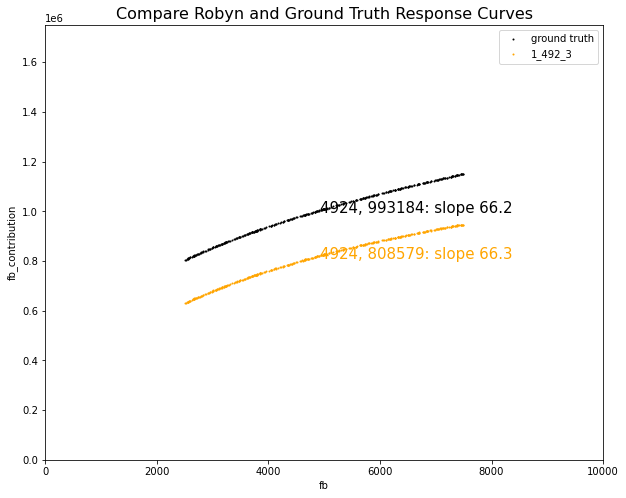

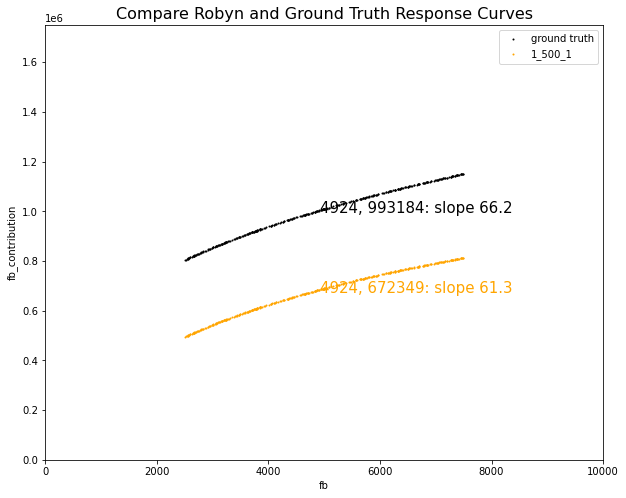

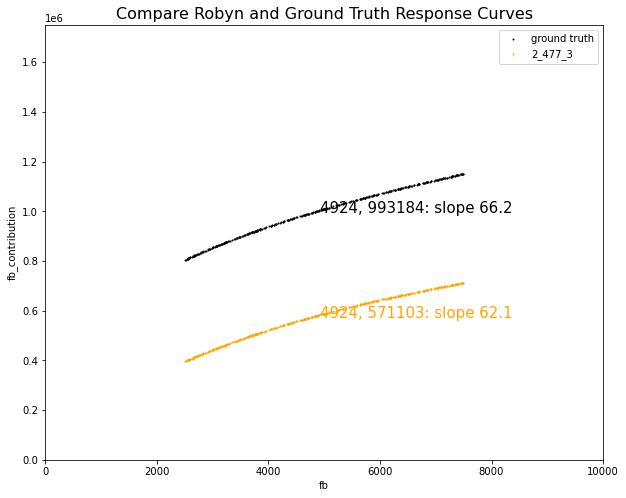

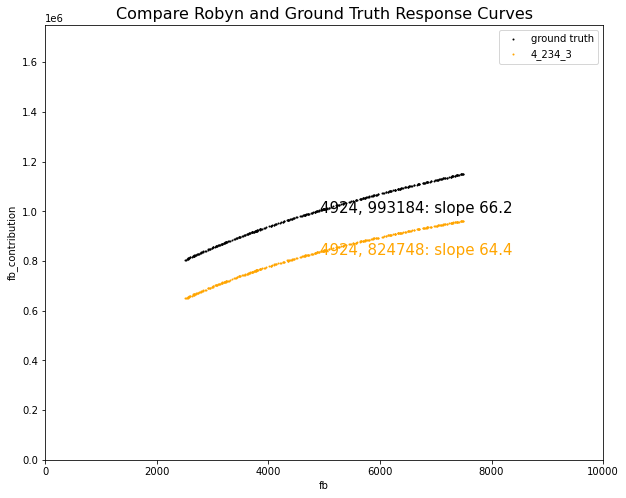

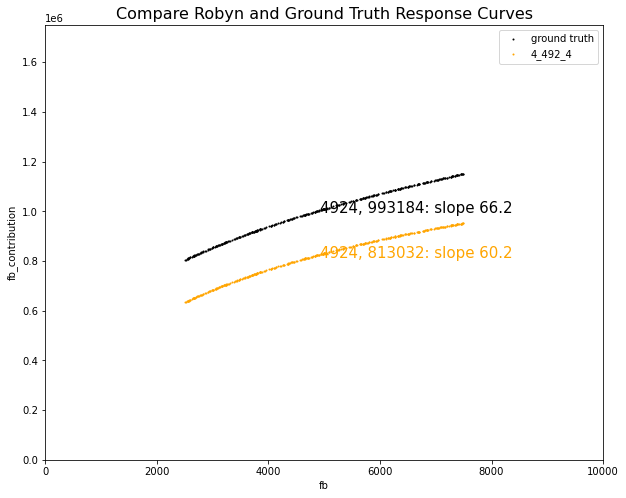

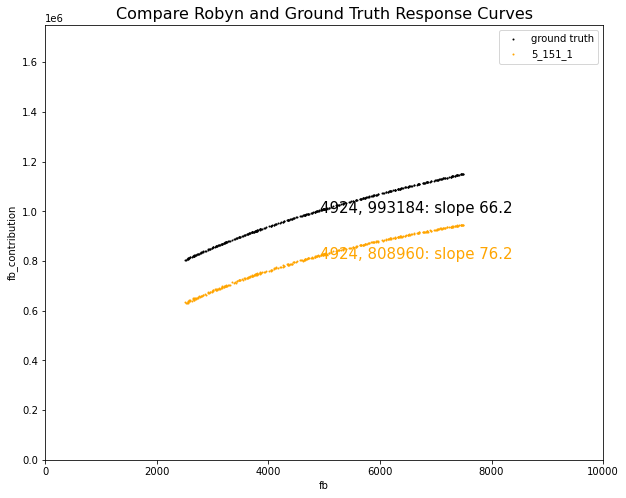

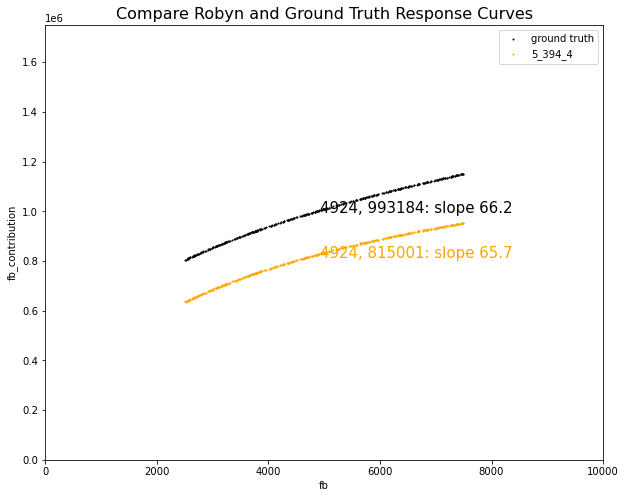

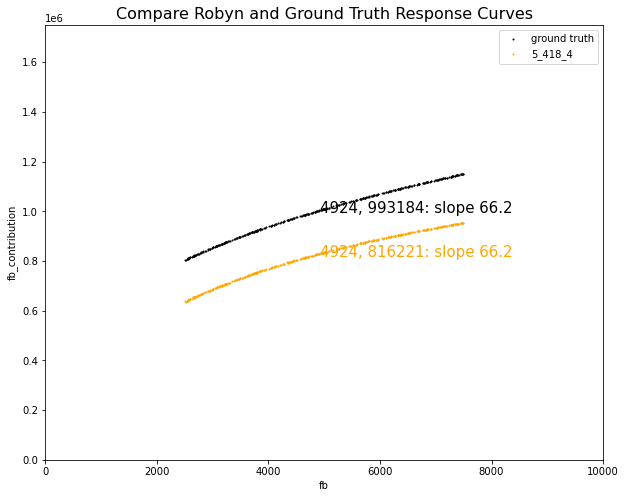

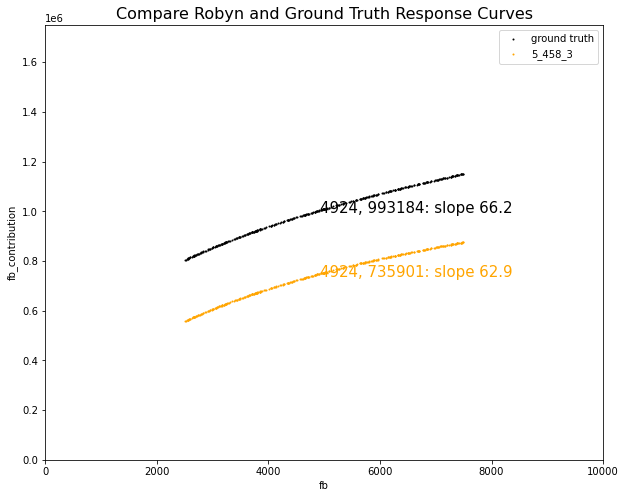

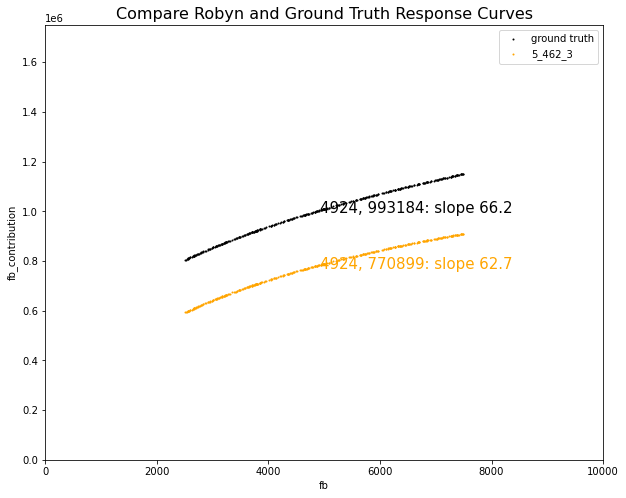

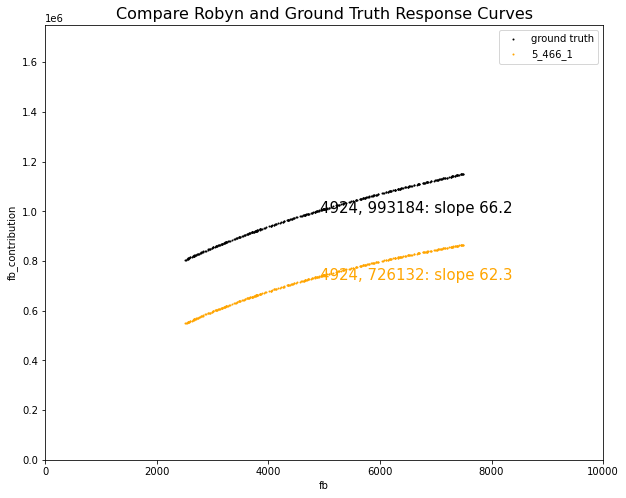

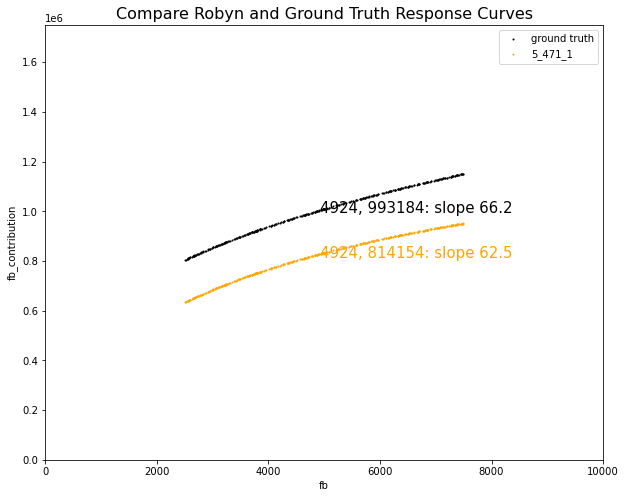

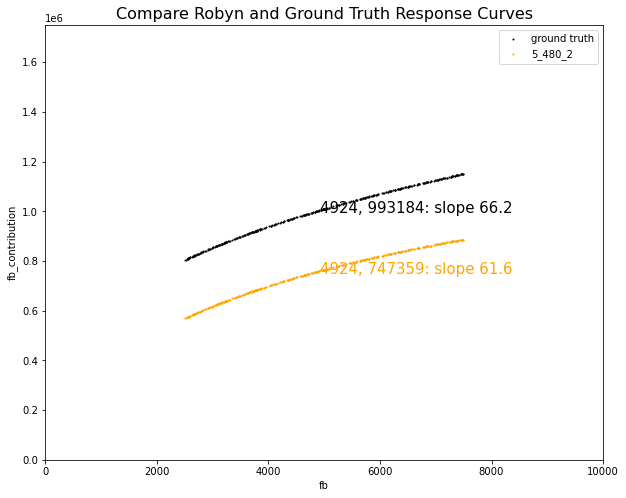

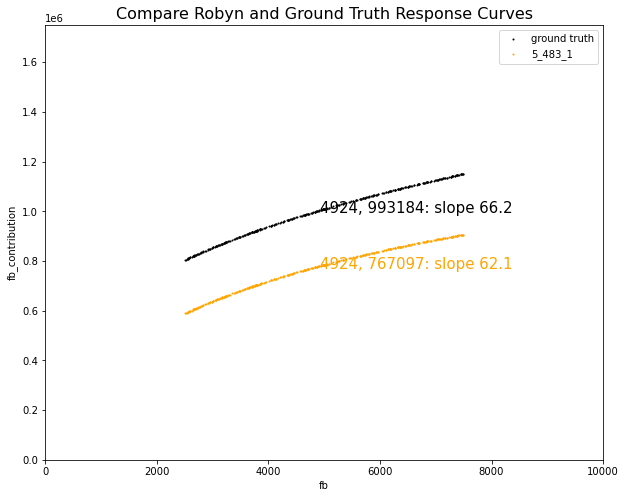

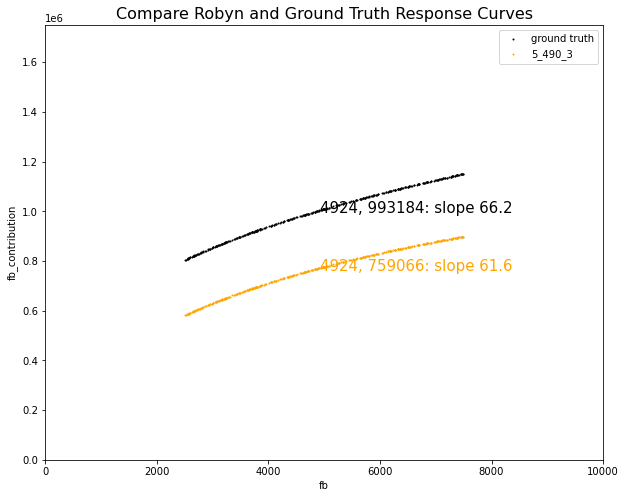

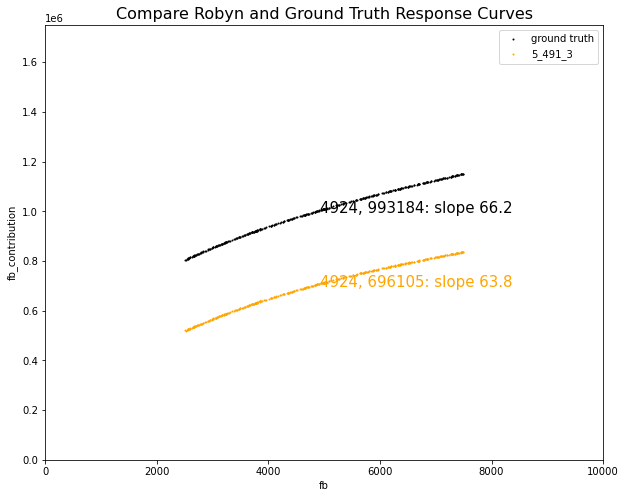

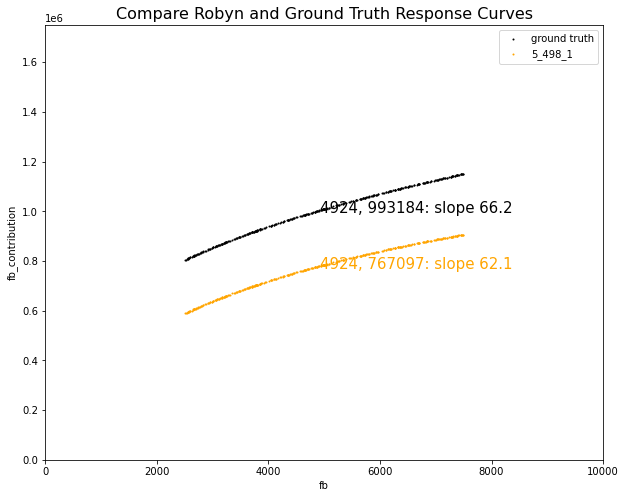

66.25
mean robyn slope: 64.26436711337257
min robyn slope: 60.2354848981943
max robyn slope: 76.17349583018103


In [6]:
def compare_robyn_ground_truth(ground_truth, robyn_results, solution_filter, figsize=(10,8), save_file=False,
                              solution_dir='2022-02-01_18.45_init'):
    '''
    compare results for solution_filter in robyn_results against ground truth
    in a chart of size figsize.  If save_file then save a png of this image
    '''
    # setup results
    rdf = robyn_results[robyn_results.solID==sol_filter]
    decomp = rdf[rdf.type=='decompMedia']
    decomp = decomp.rename(columns={'fb': 'fb_contribution'})
    spend = rdf[rdf.type=='rawSpend']
    outcome = decomp[['date','fb_contribution']].merge(spend[['date', 'fb']], how='inner')

    # plot ground truth
    ax=df2021.plot.scatter(y='fb_contribution', x='fb', s=1, label='ground truth', color='black', figsize=figsize)
    _=ax.set_ylim(0, 1750000)
    _=ax.set_xlim(0, 10000)
    _=ax.set_title('Compare Robyn and Ground Truth Response Curves', fontsize=16)

    _=outcome.plot.scatter(y='fb_contribution', x='fb', label=solution_filter, color='orange', s=1, ax=ax)
    
    # add mid points
    gtx = df2021.fb.mean()
    gty = df2021.fb_contribution.mean()
    gtslope = calc_slope_mean(df2021)
    ax.text(x=gtx, y=gty, s=f'{int(gtx)}, {int(gty)}: slope {gtslope:.1f}', color='black', fontsize=15)
    
    rx = outcome.fb.mean()
    ry = outcome.fb_contribution.mean()
    slope = calc_slope_mean_x_points(outcome)
    ax.text(x=rx, y=ry, s=f'{int(rx)}, {int(ry)}: slope {slope:.1f}', color='orange', fontsize=15)
    
    if save_file:
        # save image file for use in documentation
        filename = os.path.join('..', 'robyn_output', solution_dir, f'{solution_filter}_gt_response_compare.png')
        plt.savefig(filename)
                                
    plt.show()
    return gtslope, slope


def calc_slope_mean(df, x='fb', y='fb_contribution'):
    '''
    calculates slope of data set at mean value 
    may want this at median alternatively
    
    This only works for a continuous curve with no bumps, otherwise use the calc_slope_mean_x_points below
    '''
    mean_x = df[x].mean()
    xund = df[df[x]<mean_x][x].max()
    xover = df[df[x]>mean_x][x].min()
    yund = df[df[x]==xund][y].mean() # in case more than one obs at value
    yover = df[df[x]==xover][y].mean() # ditto
    return ((yover-yund) / (xover-xund))


def calc_slope_mean_x_points(df, points=10, x='fb', y='fb_contribution'):
    '''
    calculates the slope but uses *points* nearest points on either side of the mean
    that way the slope is not biased by any particular point being a bit "off" due to
    other effects not captured in this variable.
    
    this is required for the robyn slope estimation since there is irregularlity
    '''
    mean_x = df[x].mean()
    xund = df[df[x]<mean_x][x].nlargest(points)
    xover = df[df[x]>mean_x][x].nsmallest(points)
    xundavg = xund.mean()
    xoveravg = xover.mean()

    cum = 0
    for idx, i  in xund.iteritems():
        cum += df[df[x]==i][y].mean()
    yundavg = cum / len(xund)
    
    cum = 0
    for idx, i  in xover.iteritems():
        cum += df[df[x]==i][y].mean()
    yoveravg = cum/len(xover)
    return   ((yoveravg-yundavg) / (xoveravg-xundavg))


#
# run with solution_ids which are from Pareto Front
#

solns = pd.read_csv('solution_ids.csv')

soln_slopes = []
for cntr, sol_filter in enumerate(solns.solID):
    if cntr==0:
        save=True
    else:
        save=False
    gt_slope, soln_slope = compare_robyn_ground_truth(df2021, resdf2021, sol_filter, save_file=save)
    soln_slopes.append(soln_slope)

print(gt_slope)
slopesdf = pd.DataFrame(soln_slopes, columns=['slope'])
print(f'mean robyn slope: {slopesdf.slope.mean()}')
print(f'min robyn slope: {slopesdf.slope.min()}')
print(f'max robyn slope: {slopesdf.slope.max()}')
